## Load modules from Python/Pytorch

In [1]:
import os
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(is_gpu)

False


## Load modules from AI4PDEs

In [2]:
from AI4PDEs_utils  import create_tensors_3D, create_tensors_2D, get_weights_linear_2D, create_solid_body_2D
from AI4PDEs_bounds import boundary_condition_Dirichlet_2D, boundary_condition_Neumann_2D
from AI4PDEs_bounds import boundary_condition_inflow_2D, boundary_condition_outflow_2D
from AI4PDEs_bounds import boundary_condition_u, boundary_condition_v
from AI4PDEs_bounds import boundary_condition_p, boundary_condition_cw

## Initialise numerical parameter

In [14]:
dt = 0.05                               # Time step (s)
dx = 1.0 ; dy = 1.0                     # Grid size (m)
Re = 0.1                                # Viscosity 
ub = -1.0                               # Inflow speed (m/s)
nx = 1024 ; ny = 256                    # Grid point
lx = dx * nx ; ly = dy * ny             # Domain size (m)
nlevel = int(math.log(ny, 2)) + 1       # Multigrid level
ntime = 50000                           # Time steps 
iteration = 5                           # Multigrid iteration
bias_initializer = torch.tensor([0.0])  # Initial bias as 0 for NNs 

## Initialise numerical parameter

In [15]:
[w1, w2, w3, wA, w_res, diag] = get_weights_linear_2D(dx)

All the required filters have been created successfully!


## Establish AI4CFD Neural Network

In [16]:
class AI4CFD(nn.Module):
    """docstring for AI4CFD"""
    def __init__(self):
        super(AI4CFD, self).__init__()
        # self.arg = arg
        self.xadv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.yadv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.diff = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.A = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.res = nn.Conv2d(1, 1, kernel_size=2, stride=2, padding=0)  
        self.prol = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),)
        
        self.xadv.weight.data = w2
        self.yadv.weight.data = w3
        self.diff.weight.data = w1
        self.A.weight.data = wA
        self.res.weight.data = w_res

        self.xadv.bias.data = bias_initializer
        self.yadv.bias.data = bias_initializer
        self.diff.bias.data = bias_initializer
        self.A.bias.data = bias_initializer
        self.res.bias.data = bias_initializer
        
    def solid_body(self, values_u, values_v, sigma, dt):
        values_u = values_u / (1+dt*sigma) 
        values_v = values_v / (1+dt*sigma) 
        return values_u, values_v   
         
    def F_cycle_MG(self, values_uu, values_vv, values_p, values_pp, iteration, diag, dt, nlevel):
        b = -(self.xadv(values_uu) + self.yadv(values_vv)) / dt
        for MG in range(iteration):
            w = torch.zeros((1,1,1,1), device=device)
            r = self.A(boundary_condition_p(values_p, values_pp)) - b 
            r_s = []  
            r_s.append(r)
            for i in range(1,nlevel):
                r = self.res(r)
                r_s.append(r)
            for i in reversed(range(1,nlevel)):
                ww = boundary_condition_cw(w)
                w = w - self.A(ww) / diag + r_s[i] / diag
                w = self.prol(w)         
            values_p = values_p - w
            values_p = values_p - self.A(boundary_condition_p(values_p, values_pp)) / diag + b / diag
        return values_p, w, r
        
    def forward(self, values_u, values_uu, values_v, values_vv, values_p, values_pp, sigma, b_uu, b_vv, dt, iteration):      
        values_uu = boundary_condition_u(values_u,values_uu,ub) 
        values_vv = boundary_condition_v(values_v,values_vv,ub)  
        values_pp = boundary_condition_p(values_p,values_pp)   
        Grapx_p  = self.xadv(values_pp) * dt  ; Grapy_p = self.yadv(values_pp) * dt 
        ADx_u = self.xadv(values_uu) ; ADy_u = self.yadv(values_uu) 
        ADx_v = self.xadv(values_vv) ; ADy_v = self.yadv(values_vv) 
        AD2_u = self.diff(values_uu) ; AD2_v = self.diff(values_vv) 
    # First step for solving uvw
        b_u = values_u + 0.5 * (Re * AD2_u * dt - values_u * ADx_u * dt - values_v * ADy_u * dt) - Grapx_p 
        b_v = values_v + 0.5 * (Re * AD2_v * dt - values_u * ADx_v * dt - values_v * ADy_v * dt) - Grapy_p 
        [b_u, b_v] = self.solid_body(b_u, b_v, sigma, dt)
    # Padding velocity vectors 
        b_uu = boundary_condition_u(b_u,b_uu,ub) 
        b_vv = boundary_condition_v(b_v,b_vv,ub) 
        ADx_u = self.xadv(b_uu) ; ADy_u = self.yadv(b_uu) 
        ADx_v = self.xadv(b_vv) ; ADy_v = self.yadv(b_vv) 
        AD2_u = self.diff(b_uu) ; AD2_v = self.diff(b_vv) 
    # Second step for solving uvw   
        values_u = values_u + Re * AD2_u * dt - b_u * ADx_u * dt - b_v * ADy_u * dt - Grapx_p 
        values_v = values_v + Re * AD2_v * dt - b_u * ADx_v * dt - b_v * ADy_v * dt - Grapy_p 
        [values_u, values_v] = self.solid_body(values_u, values_v, sigma, dt)
    # pressure
        values_uu = boundary_condition_u(values_u,values_uu,ub) 
        values_vv = boundary_condition_v(values_v,values_vv,ub)  
        [values_p, w ,r] = self.F_cycle_MG(values_uu, values_vv, values_p, values_pp, iteration, diag, dt, nlevel)
    # Pressure gradient correction    
        values_pp = boundary_condition_p(values_p, values_pp)  
        values_u = values_u - self.xadv(values_pp) * dt ; values_v = values_v - self.yadv(values_pp) * dt 
        [values_u, values_v] = self.solid_body(values_u, values_v, sigma, dt)
        return values_u, values_v, values_p, w, r

## Send the model to GPU

In [17]:
AI4CFD = AI4CFD().to(device)

## Create initial tensors 

In [18]:
values_u, values_v, values_p, values_uu, values_vv, values_pp, b_uu, b_vv = create_tensors_2D(nx, ny)

All the required tensors have been created successfully!


## Create a bluff body in the domain

In [19]:
cor_x = 145
cor_y = int(ny/2)
size_x = 25
size_y = 25
sigma = create_solid_body_2D(nx, ny, cor_x, cor_y, size_x, size_y)

A bluff body has been created successfully!


## Visualise the generated bluff body 

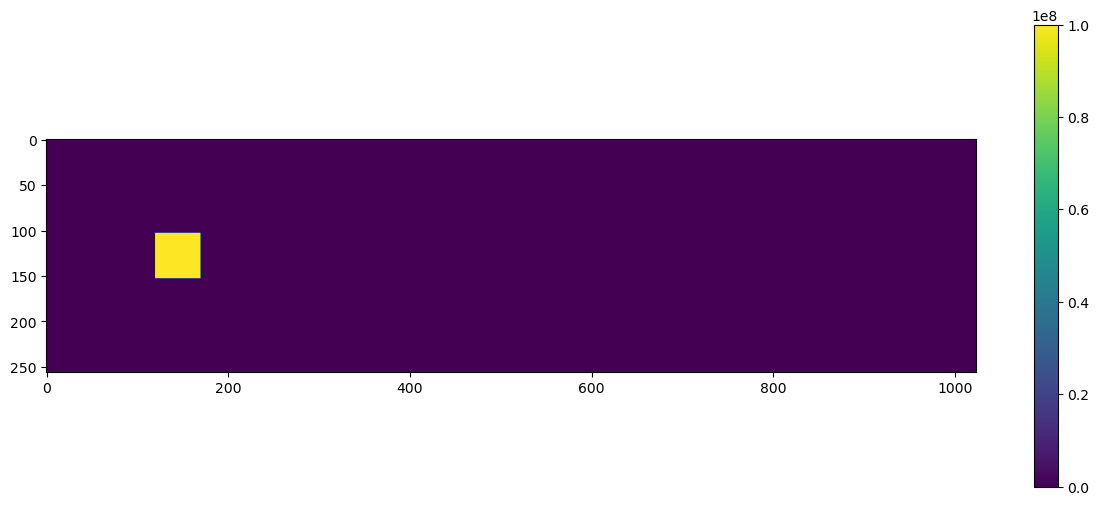

In [20]:
plt.figure(figsize=(15, 6))
plt.imshow(sigma[0,0,:,:].cpu())
plt.colorbar()
# plt.axis('off')

## Run AI4CFD solver

In [21]:
start = time.time()
print("======================================================================")
print("Welcome to AI4CFD solver that will generate flow past a block for you!")
print("======================================================================")
with torch.no_grad():
    for itime in range(1,ntime+1):
        [values_u,values_v,values_p,w,r] = AI4CFD(values_u,values_uu,values_v,values_vv,values_p,values_pp,sigma,b_uu,b_vv,dt,iteration)
        if itime % 500 == 0:
            print('Time step:', itime, 'Pressure residual:',"{:.5f}".format(np.max(np.abs(w.cpu().detach().numpy()))))  
        if np.max(np.abs(w.cpu().detach().numpy())) > 80000.0:
            print('Not converged !!!!!!')
            break
end = time.time()
print('Elapsed time:', end - start)

Welcome to AI4CFD solver that will generate flow past a block for you!
Time step: 500 Pressure residual: 0.15836
Time step: 1000 Pressure residual: 0.07096
Elapsed time: 69.33738994598389


## Visualise u component velocity in x direction

Text(0.5, 1.0, 'u component velocity (m/s)')

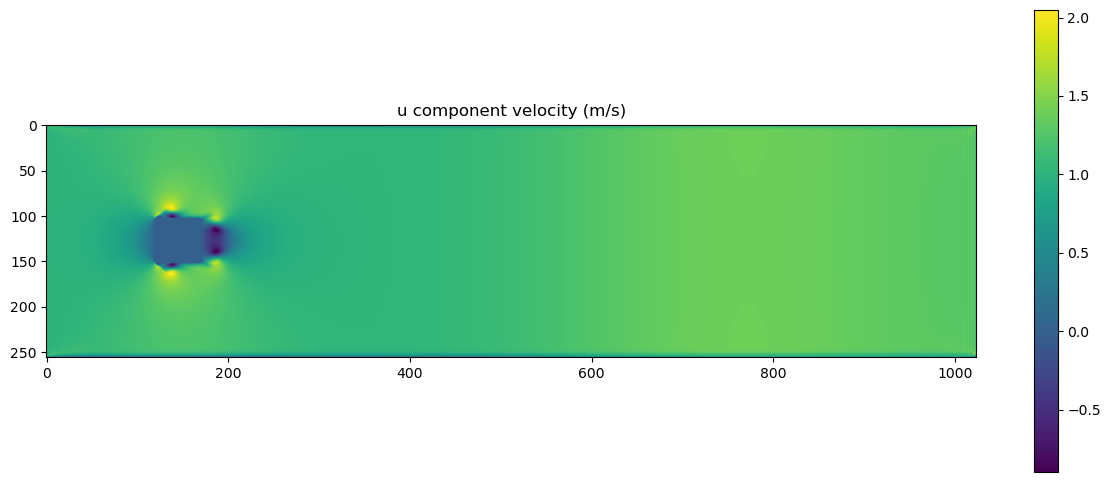

In [22]:
plt.figure(figsize=(15, 6))
plt.imshow(-values_u[0,0,:,:].cpu())
plt.colorbar()
plt.title('u component velocity (m/s)')
# plt.axis('off')

## Visualise v component velocity in x direction

Text(0.5, 1.0, 'v component velocity (m/s)')

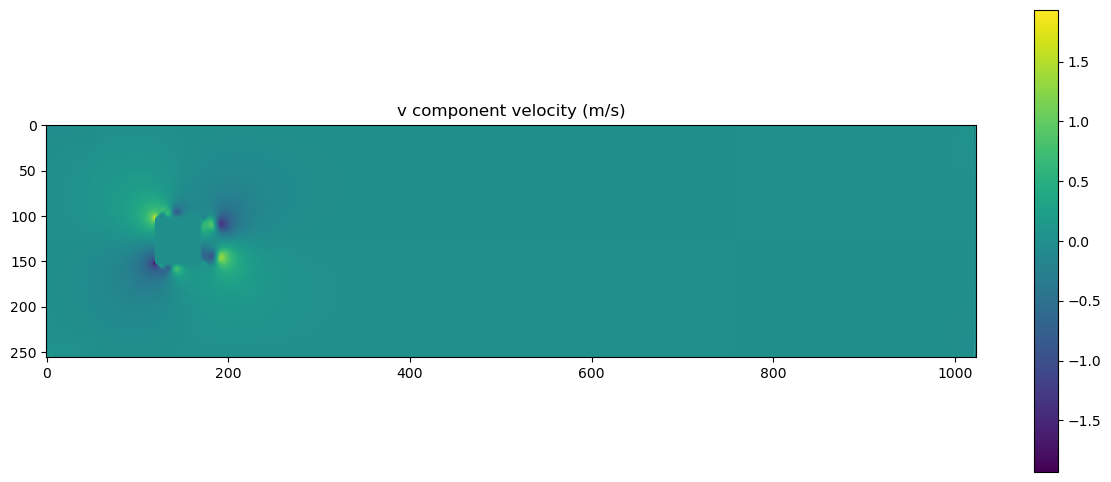

In [23]:
plt.figure(figsize=(15, 6))
plt.imshow(-values_v[0,0,:,:].cpu())
plt.colorbar()
plt.title('v component velocity (m/s)')